In [24]:
import torch
import IPython.display as ipd

import matplotlib.pyplot as plt
import librosa
import soundfile
import torchaudio

from cl_tts.utils.generic import load_params

In [5]:
def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1, figsize=(10, 5))
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)

def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)

In [10]:
hparams_path = "../hparams/speaker_incremental/naive.yml"
params = load_params(hparams_path)["VCTK-Speaker-Inc[Tac2NV]"]["ap_params"]

## Load Audio

max:  tensor(0.2239)
min:  tensor(-0.1787)


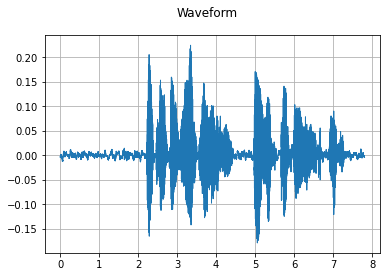

In [29]:
audio_path = "../data/VCTK-mini/audios/vctk_speaker336/audio041.wav"
x, sr = torchaudio.load(audio_path)
print("max: ", torch.max(x))
print("min: ", torch.min(x))

plot_waveform(x, sample_rate=params["sample_rate"])

soundfile.write("../out/sample.wav", x.squeeze().numpy(), sr)
ipd.Audio(x, rate=sr)

## Spectrogram

max:  tensor(914.4245)
min:  tensor(4.8637e-12)


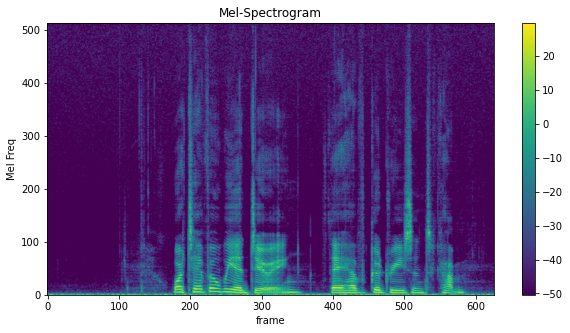

In [17]:
transform_spec = torchaudio.transforms.Spectrogram(
            n_fft=params["n_fft"],
            win_length=params["win_length"],
            hop_length=params["hop_length"],
            center=True,
            pad_mode="reflect",
            power=2.0)

spec = transform_spec(x)
print("max: ", torch.max(spec))
print("min: ", torch.min(spec))

plot_spectrogram(spec[0], title="Mel-Spectrogram", ylabel='Mel Freq')

## Griffin-Lim

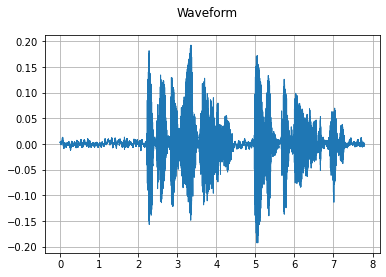

In [34]:
griffin_lim = torchaudio.transforms.GriffinLim(
    n_fft=params["n_fft"],
    win_length=params["win_length"],
    hop_length=params["hop_length"]
)
x_rec = griffin_lim(spec)

plot_waveform(x_rec, sample_rate=params["sample_rate"])

soundfile.write("../out/sample.wav", x_rec.squeeze().numpy(), sr)
ipd.Audio(x_rec, rate=sr)

## Mel-Spectrogram

max:  tensor(29.5136)
min:  tensor(2.9559e-09)


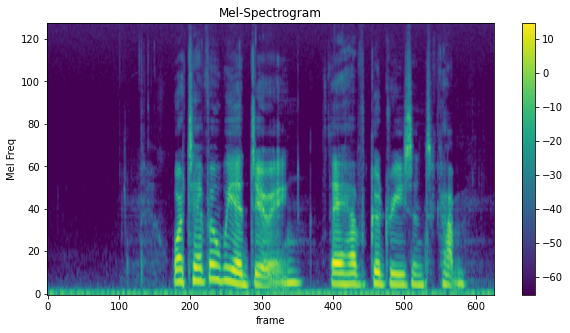

In [20]:
transform_mel_spec = torchaudio.transforms.MelSpectrogram(
    sample_rate=params["sample_rate"],
    n_fft=params["n_fft"],
    win_length=params["win_length"],
    hop_length=params["hop_length"],
    center=True,
    pad_mode="reflect",
    power=2.0,
    norm='slaney',
    onesided=True,
    n_mels=params["n_mels"],
    mel_scale="htk",
)

mel_spec = transform_mel_spec(x)
print("max: ", torch.max(mel_spec))
print("min: ", torch.min(mel_spec))

plot_spectrogram(mel_spec[0], title="Mel-Spectrogram", ylabel='Mel Freq')


## Mel-Spec -> Spec -> Waveform

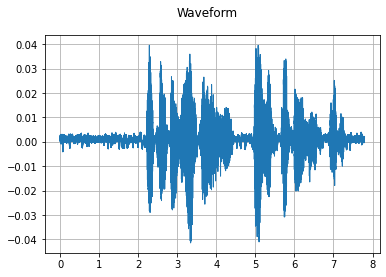

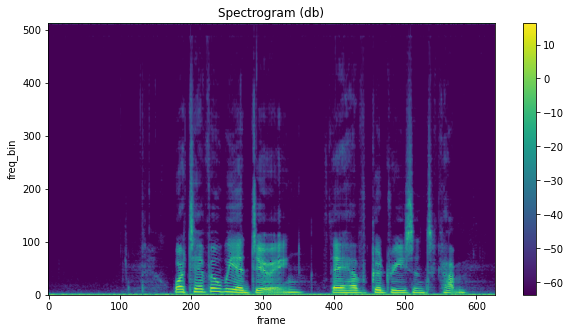

In [33]:
transform_inv_mel = torchaudio.transforms.InverseMelScale(
    n_stft=params["n_fft"]//2+1,
    n_mels=params["n_mels"],
    sample_rate=params["sample_rate"],
    f_min=params["f_min"],
    f_max=params["f_max"],
    max_iter=1000,
    tolerance_loss=1e-10,
    tolerance_change=1e-10,
    mel_scale="htk",
    sgdargs={'lr': 10.9, "momentum": 0.9}
)

spec_rec = transform_inv_mel(mel_spec)
x_rec2 = griffin_lim(spec_rec)

plot_waveform(x_rec2, sample_rate=params["sample_rate"])
plot_spectrogram(spec_rec[0])
soundfile.write("../out/sample.wav", x_rec2.squeeze().numpy(), sr)

ipd.Audio(x_rec2, rate=sr)